<a href="https://colab.research.google.com/github/ai-fast-track/timeseries/blob/master/nbs/Colab_timeseries_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab Tutorial - Univariate Time Series Classification
> A tutorial that can be run in Google Colab or on a local machine

In [ ]:
!pip install git+https://github.com/fastai/fastai2.git

In [ ]:
!pip install git+https://github.com/ai-fast-track/timeseries.git

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai2.basics import *

In [ ]:
# hide
# Only for Windows users because symlink to `timeseries` folder is not recognized by Windows
import sys
sys.path.append("..")

In [ ]:
from timeseries.all import *

In [ ]:
dsname =  'Yoga' # 'ChlorineConcentration', 'Yoga'

In [ ]:
url = 'http://www.timeseriesclassification.com/Downloads/Yoga.zip'
path = unzip_data(url)
# path = unzip_data(URLs_TS.NATOPS)
path

Path('/home/farid/.fastai/data/Yoga')

In [ ]:
fname_train = f'{dsname}_TRAIN.arff'
fname_test = f'{dsname}_TEST.arff'
fnames = [path/fname_train, path/fname_test]
fnames

[Path('/home/farid/.fastai/data/Yoga/Yoga_TRAIN.arff'),
 Path('/home/farid/.fastai/data/Yoga/Yoga_TEST.arff')]

In [ ]:
data = TSData.from_arff(fnames)
print(data)

TSData:
 Datasets names (concatenated): ['Yoga_TRAIN', 'Yoga_TEST']
 Filenames:                     [Path('/home/farid/.fastai/data/Yoga/Yoga_TRAIN.arff'), Path('/home/farid/.fastai/data/Yoga/Yoga_TEST.arff')]
 Data shape: (3300, 1, 426)
 Targets shape: (3300,)
 Nb Samples: 3300
 Nb Channels:           1
 Sequence Length: 426


In [ ]:
items = data.get_items()

In [ ]:
seed = 42
splits = RandomSplitter(seed=seed)(range_of(items)) #by default 80% for train split and 20% for valid split are chosen 
splits

((#2640) [1683,2715,2242,824,768,1022,2227,1359,59,1381...],
 (#660) [3042,387,98,1891,430,2595,1282,2909,1774,1682...])

In [ ]:
bs = 128                            
# Normalize at batch time
tfm_norm = Normalize(scale_subtype = 'per_sample_per_channel', scale_range=(0, 1)) # per_sample , per_sample_per_channel
# tfm_norm = Standardize(scale_subtype = 'per_sample')
batch_tfms = [tfm_norm]

In [ ]:
default_device()

device(type='cpu')

In [ ]:
# dls = TSDataLoaders.from_files(fnames=fnames, batch_tfms=batch_tfms, num_workers=0, device=default_device())
dls = TSDataLoaders.from_files(fnames=fnames, num_workers=0, device=default_device())

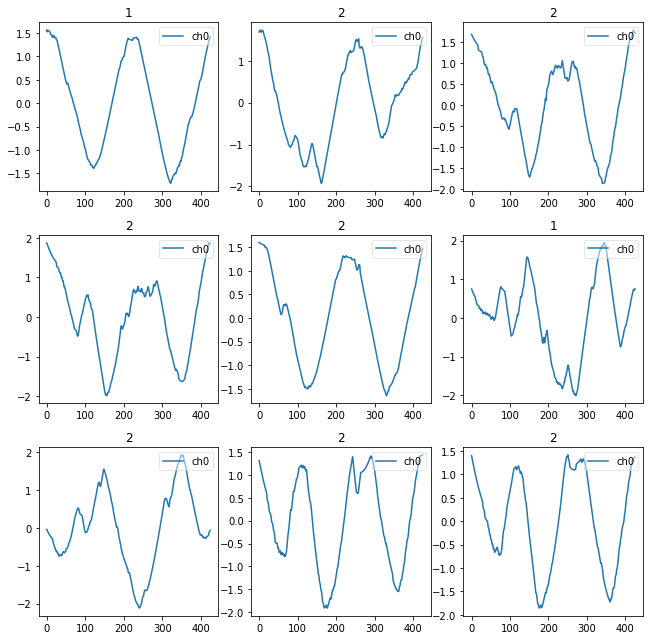

In [ ]:
dls.show_batch(max_n=9)

# Train Model

In [ ]:
# Number of channels (i.e. dimensions in ARFF and TS files jargon)
c_in = get_n_channels(dls.train) # data.n_channels
# Number of classes
c_out= dls.c 
c_in,c_out

(1, 2)

In [ ]:
model = inception_time(c_in, c_out).to(device=default_device())
model

Sequential(
  (0): SequentialEx(
    (layers): ModuleList(
      (0): InceptionModule(
        (convs): ModuleList(
          (0): Conv1d(1, 32, kernel_size=(39,), stride=(1,), padding=(19,), bias=False)
          (1): Conv1d(1, 32, kernel_size=(19,), stride=(1,), padding=(9,), bias=False)
          (2): Conv1d(1, 32, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
        )
        (maxpool_bottleneck): Sequential(
          (0): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
          (1): Conv1d(1, 32, kernel_size=(1,), stride=(1,), bias=False)
        )
        (bn_relu): Sequential(
          (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU()
        )
      )
    )
  )
  (1): SequentialEx(
    (layers): ModuleList(
      (0): InceptionModule(
        (bottleneck): Conv1d(128, 32, kernel_size=(1,), stride=(1,))
        (convs): ModuleList(
          (0): Conv1d(32, 32, kernel_size=(39,), 

In [ ]:
# opt_func = partial(Adam, lr=3e-3, wd=0.01)
#Or use Ranger
def opt_func(p, lr=slice(3e-3)): return Lookahead(RAdam(p, lr=lr, mom=0.95, wd=0.01)) 

In [ ]:
#Learner
loss_func = LabelSmoothingCrossEntropy() 
learn = Learner(dls, model, opt_func=opt_func, loss_func=loss_func, metrics=accuracy)

print(learn.summary())

Sequential (Input shape: ['64 x 1 x 426'])
Layer (type)         Output Shape         Param #    Trainable 
Conv1d               64 x 32 x 426        1,248      True      
________________________________________________________________
Conv1d               64 x 32 x 426        608        True      
________________________________________________________________
Conv1d               64 x 32 x 426        288        True      
________________________________________________________________
MaxPool1d            64 x 1 x 426         0          False     
________________________________________________________________
Conv1d               64 x 32 x 426        32         True      
________________________________________________________________
BatchNorm1d          64 x 128 x 426       256        True      
________________________________________________________________
ReLU                 64 x 128 x 426       0          False     
_______________________________________________________

(0.014454397559165954, 4.3651581904669e-07)

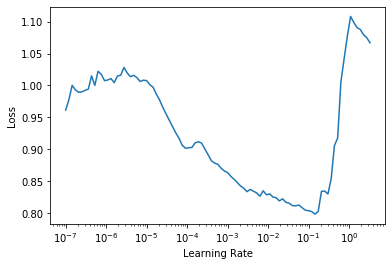

In [ ]:
lr_min, lr_steep = learn.lr_find()
lr_min, lr_steep

In [ ]:
lr_max=1e-3 # lr_max=lr_steep
epochs=10; lr_max=lr_max;  pct_start=.7; moms=(0.95,0.85,0.95); wd=1e-2
learn.fit_one_cycle(epochs, lr_max=lr_max, pct_start=pct_start,  moms=moms, wd=wd)
# learn.fit_one_cycle(epochs, lr_max=lr_steep)

epoch,train_loss,valid_loss,accuracy,time
0,0.704212,0.707301,0.559091,01:14
1,0.582890,0.498229,0.843939,01:14
2,0.502958,0.454466,0.824242,01:18
3,0.459400,0.430813,0.853030,01:26
4,0.459093,0.417426,0.892424,01:24
5,0.414254,0.349961,0.913636,01:22
6,0.387793,0.371689,0.907576,01:22
7,0.337894,0.315346,0.940909,01:19
8,0.292890,0.277478,0.960606,01:21
9,0.259528,0.267797,0.965151,01:22


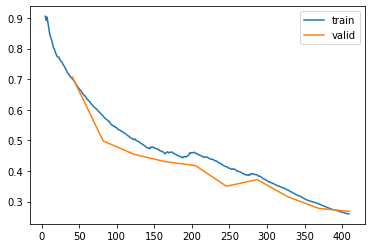

In [ ]:
learn.recorder.plot_loss()

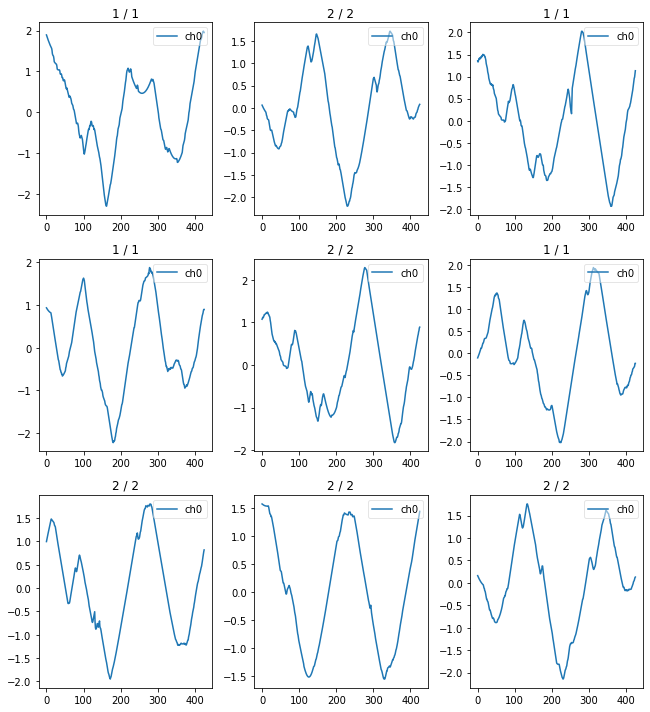

In [ ]:
learn.show_results(max_n=9)

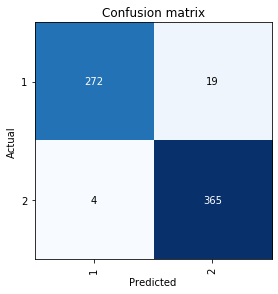

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.most_confused()

[('1', '2', 19), ('2', '1', 4)]

<img src="https://github.com/ai-fast-track/timeseries/blob/master/images/nature-red-forest-leaves.jpg?raw=1" width="1440" height="840" alt=""/>